<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek41.do.txt  -->
<!-- dom:TITLE: Exercises week 41 -->

# Exercises week 41
**October 9-13, 2023**

Date: **Deadline is Sunday October 15 at midnight**

# Overarching aims of the exercises this week

The aim of the exercises this week is to get started with implementing
gradient methods of relevance for project 2. This exercise will also
be continued next week with the addition of automatic differentation.
Everything you develop here will be used in project 2. 

In order to get started, we will now replace in our standard ordinary
least squares (OLS) and Ridge regression codes (from project 1) the
matrix inversion algorithm with our own gradient descent (GD) and SGD
codes.  You can use the Franke function or the terrain data from
project 1. **However, we recommend using a simpler function like**
$f(x)=a_0+a_1x+a_2x^2$ or higher-order one-dimensional polynomials.
You can obviously test your final codes against for example the Franke
function. Automatic differentiation will be discussed next week.

You should include in your analysis of the GD and SGD codes the following elements
1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression of the gradients

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate), again using the analytical expression of the gradients.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

The lecture notes from weeks 39 and 40 contain more information and code examples. Feel free to use these examples.

In summary, you should 
perform an analysis of the results for OLS and Ridge regression as
function of the chosen learning rates, the number of mini-batches and
epochs as well as algorithm for scaling the learning rate. You can
also compare your own results with those that can be obtained using
for example **Scikit-Learn**'s various SGD options.  Discuss your
results. For Ridge regression you need now to study the results as functions of  the hyper-parameter $\lambda$ and 
the learning rate $\eta$.  Discuss your results.

You will need your SGD code for the setup of the Neural Network and
Logistic Regression codes. You will find the Python [Seaborn
package](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
useful when plotting the results as function of the learning rate
$\eta$ and the hyper-parameter $\lambda$ when you use Ridge
regression.

We recommend reading chapter 8 on optimization from the textbook of [Goodfellow, Bengio and Courville](https://www.deeplearningbook.org/). This chapter contains many useful insights and discussions on the optimization part of machine learning.

# Code examples from week 39 and 40

## Code with a Number of Minibatches which varies, analytical gradient

In the code here we vary the number of mini-batches.

Own inversion
[[4.11317647]
 [2.89590113]]
Eigenvalues of Hessian Matrix:[0.30572664 4.2933372 ]
theta from own gd
[[4.11317647]
 [2.89590113]]
theta from own sdg
[[4.11054282]
 [2.90860481]]


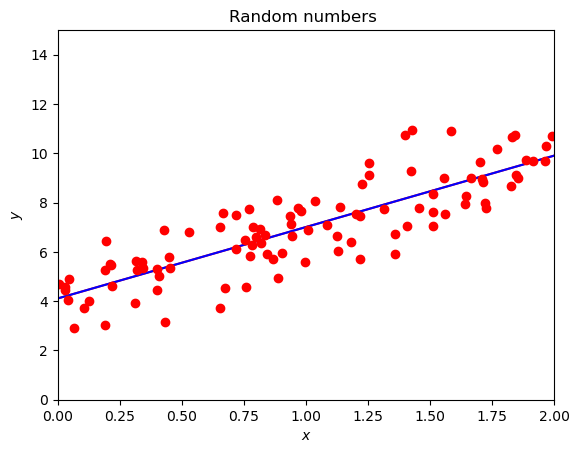

In [1]:
%matplotlib inline

# Importing various packages
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

theta = np.random.randn(2,1)
eta = 1.0/np.max(EigValues)
Niterations = 1000

# need convergence tests
# stop if reached max number of iterations or | new value - old value | =< given tolerance
for iter in range(Niterations):
    gradients = 2.0/n*X.T @ ((X @ theta)-y)
    theta -= eta*gradients
print("theta from own gd")
print(theta)

xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
t0, t1 = 5, 50

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
# Can you figure out a better way of setting up the contributions to each batch?
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (2.0/M)* xi.T @ ((xi @ theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta*gradients
print("theta from own sdg")
print(theta)

plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Random numbers ')
plt.show()

In the above code, we have use replacement in setting up the
mini-batches. The discussion
[here](https://sebastianraschka.com/faq/docs/sgd-methods.html) may be
useful.

## Momentum based GD

The stochastic gradient descent (SGD) is almost always used with a
*momentum* or inertia term that serves as a memory of the direction we
are moving in parameter space.  This is typically implemented as
follows

$$
\mathbf{v}_{t}=\gamma \mathbf{v}_{t-1}+\eta_{t}\nabla_\theta E(\boldsymbol{\theta}_t) \nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation} 
\boldsymbol{\theta}_{t+1}= \boldsymbol{\theta}_t -\mathbf{v}_{t},
\label{_auto1} \tag{1}
\end{equation}
$$

where we have introduced a momentum parameter $\gamma$, with
$0\le\gamma\le 1$, and for brevity we dropped the explicit notation to
indicate the gradient is to be taken over a different mini-batch at
each step. We call this algorithm gradient descent with momentum
(GDM). From these equations, it is clear that $\mathbf{v}_t$ is a
running average of recently encountered gradients and
$(1-\gamma)^{-1}$ sets the characteristic time scale for the memory
used in the averaging procedure. Consistent with this, when
$\gamma=0$, this just reduces down to ordinary SGD as discussed
earlier. An equivalent way of writing the updates is

$$
\Delta \boldsymbol{\theta}_{t+1} = \gamma \Delta \boldsymbol{\theta}_t -\ \eta_{t}\nabla_\theta E(\boldsymbol{\theta}_t),
$$

where we have defined $\Delta \boldsymbol{\theta}_{t}= \boldsymbol{\theta}_t-\boldsymbol{\theta}_{t-1}$.

## Algorithms and codes for Adagrad, RMSprop and Adam

The algorithms we have implemented are well described in the text by [Goodfellow, Bengio and Courville, chapter 8](https://www.deeplearningbook.org/contents/optimization.html).

The codes which implement these algorithms are discussed after our presentation of automatic differentiation.

## Practical tips

* **Randomize the data when making mini-batches**. It is always important to randomly shuffle the data when forming mini-batches. Otherwise, the gradient descent method can fit spurious correlations resulting from the order in which data is presented.

* **Transform your inputs**. Learning becomes difficult when our landscape has a mixture of steep and flat directions. One simple trick for minimizing these situations is to standardize the data by subtracting the mean and normalizing the variance of input variables. Whenever possible, also decorrelate the inputs. To understand why this is helpful, consider the case of linear regression. It is easy to show that for the squared error cost function, the Hessian of the cost function is just the correlation matrix between the inputs. Thus, by standardizing the inputs, we are ensuring that the landscape looks homogeneous in all directions in parameter space. Since most deep networks can be viewed as linear transformations followed by a non-linearity at each layer, we expect this intuition to hold beyond the linear case.

* **Monitor the out-of-sample performance.** Always monitor the performance of your model on a validation set (a small portion of the training data that is held out of the training process to serve as a proxy for the test set. If the validation error starts increasing, then the model is beginning to overfit. Terminate the learning process. This *early stopping* significantly improves performance in many settings.

* **Adaptive optimization methods don't always have good generalization.** Recent studies have shown that adaptive methods such as ADAM, RMSPorp, and AdaGrad tend to have poor generalization compared to SGD or SGD with momentum, particularly in the high-dimensional limit (i.e. the number of parameters exceeds the number of data points). Although it is not clear at this stage why these methods perform so well in training deep neural networks, simpler procedures like properly-tuned SGD may work as well or better in these applications.

Geron's text, see chapter 11, has several interesting discussions.

## Using Automatic differentation with OLS

We conclude the part on optmization by showing how we can make codes
for linear regression and logistic regression using **autograd**. The
first example shows results with ordinary leats squares.

Own inversion
[[4.01498551]
 [3.02821089]]
Eigenvalues of Hessian Matrix:[0.29611739 4.55853898]
theta from own gd
[[4.01498551]
 [3.02821089]]


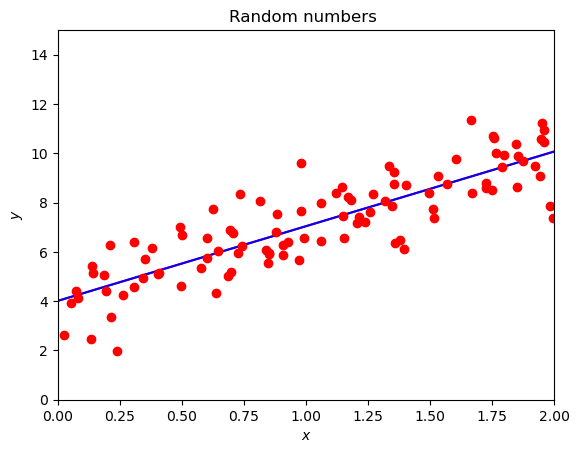

In [1]:
# Using Autograd to calculate gradients for OLS
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

def CostOLS(beta):
    return (1.0/n)*np.sum((y-X @ beta)**2)

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

theta = np.random.randn(2,1)
eta = 1.0/np.max(EigValues)
Niterations = 1000
# define the gradient
training_gradient = grad(CostOLS)

for iter in range(Niterations):
    gradients = training_gradient(theta)
    theta -= eta*gradients
print("theta from own gd")
print(theta)

xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Random numbers ')
plt.show()

## Same code but now with momentum gradient descent

In [2]:
# Using Autograd to calculate gradients for OLS
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

def CostOLS(beta):
    return (1.0/n)*np.sum((y-X @ beta)**2)

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x#+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

theta = np.random.randn(2,1)
eta = 1.0/np.max(EigValues)
Niterations = 30

# define the gradient
training_gradient = grad(CostOLS)

for iter in range(Niterations):
    gradients = training_gradient(theta)
    theta -= eta*gradients
    print(iter,gradients[0],gradients[1])
print("theta from own gd")
print(theta)

# Now improve with momentum gradient descent
change = 0.0
delta_momentum = 0.3
for iter in range(Niterations):
    # calculate gradient
    gradients = training_gradient(theta)
    # calculate update
    new_change = eta*gradients+delta_momentum*change
    # take a step
    theta -= new_change
    # save the change
    change = new_change
    print(iter,gradients[0],gradients[1])
print("theta from own gd wth momentum")
print(theta)

Own inversion
[[4.]
 [3.]]
Eigenvalues of Hessian Matrix:[0.3114293  4.37490988]
0 [-11.29166089] [-12.67848646]
1 [-0.32626599] [0.27511094]
2 [-0.30304065] [0.25552709]
3 [-0.28146861] [0.23733731]
4 [-0.26143218] [0.22044238]
5 [-0.24282205] [0.20475012]
6 [-0.22553668] [0.19017492]
7 [-0.20948179] [0.17663726]
8 [-0.19456976] [0.16406329]
9 [-0.18071925] [0.15238439]
10 [-0.1678547] [0.14153686]
11 [-0.15590591] [0.13146152]
12 [-0.1448077] [0.12210339]
13 [-0.13449952] [0.11341142]
14 [-0.12492513] [0.10533819]
15 [-0.1160323] [0.09783966]
16 [-0.1077725] [0.09087491]
17 [-0.10010068] [0.08440596]
18 [-0.09297498] [0.07839749]
19 [-0.08635653] [0.07281674]
20 [-0.08020922] [0.06763326]
21 [-0.0744995] [0.06281877]
22 [-0.06919623] [0.05834699]
23 [-0.06427047] [0.05419354]
24 [-0.05969536] [0.05033576]
25 [-0.05544593] [0.04675259]
26 [-0.05149899] [0.0434245]
27 [-0.04783302] [0.04033331]
28 [-0.04442801] [0.03746217]
29 [-0.04126539] [0.03479541]
theta from own gd
[[3.87692905]


## But noen of these can compete with Newton's method

In [4]:
# Using Newton's method
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

def CostOLS(beta):
    return (1.0/n)*np.sum((y-X @ beta)**2)

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X
beta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(beta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
# Note that here the Hessian does not depend on the parameters beta
invH = np.linalg.pinv(H)
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

beta = np.random.randn(2,1)
Niterations = 5

# define the gradient
training_gradient = grad(CostOLS)

for iter in range(Niterations):
    gradients = training_gradient(beta)
    beta -= invH @ gradients
    print(iter,gradients[0],gradients[1])
print("beta from own Newton code")
print(beta)

## Including Stochastic Gradient Descent with Autograd
In this code we include the stochastic gradient descent approach discussed above. Note here that we specify which argument we are taking the derivative with respect to when using **autograd**.

In [5]:
# Using Autograd to calculate gradients using SGD
# OLS example
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

# Note change from previous example
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

theta = np.random.randn(2,1)
eta = 1.0/np.max(EigValues)
Niterations = 1000

# Note that we request the derivative wrt third argument (theta, 2 here)
training_gradient = grad(CostOLS,2)

for iter in range(Niterations):
    gradients = (1.0/n)*training_gradient(y, X, theta)
    theta -= eta*gradients
print("theta from own gd")
print(theta)

xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Random numbers ')
plt.show()

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
# Can you figure out a better way of setting up the contributions to each batch?
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi, xi, theta)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta*gradients
print("theta from own sdg")
print(theta)

## Same code but now with momentum gradient descent

In [6]:
# Using Autograd to calculate gradients using SGD
# OLS example
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

# Note change from previous example
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

theta = np.random.randn(2,1)
eta = 1.0/np.max(EigValues)
Niterations = 100

# Note that we request the derivative wrt third argument (theta, 2 here)
training_gradient = grad(CostOLS,2)

for iter in range(Niterations):
    gradients = (1.0/n)*training_gradient(y, X, theta)
    theta -= eta*gradients
print("theta from own gd")
print(theta)


n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

change = 0.0
delta_momentum = 0.3

for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi, xi, theta)
        eta = learning_schedule(epoch*m+i)
        # calculate update
        new_change = eta*gradients+delta_momentum*change
        # take a step
        theta -= new_change
        # save the change
        change = new_change
print("theta from own sdg with momentum")
print(theta)

## AdaGrad algorithm, taken from [Goodfellow et al](https://www.deeplearningbook.org/contents/optimization.html)

<!-- dom:FIGURE: [figures/adagrad.png, width=600 frac=0.8] -->
<!-- begin figure -->

<img src="figures/adagrad.png" width="600"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## Similar (second order function now) problem but now with AdaGrad

In [7]:
# Using Autograd to calculate gradients using AdaGrad and Stochastic Gradient descent
# OLS example
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

# Note change from previous example
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

n = 1000
x = np.random.rand(n,1)
y = 2.0+3*x +4*x*x

X = np.c_[np.ones((n,1)), x, x*x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)


# Note that we request the derivative wrt third argument (theta, 2 here)
training_gradient = grad(CostOLS,2)
# Define parameters for Stochastic Gradient Descent
n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
# Guess for unknown parameters theta
theta = np.random.randn(3,1)

# Value for learning rate
eta = 0.01
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8
for epoch in range(n_epochs):
    Giter = 0.0
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi, xi, theta)
        Giter += gradients*gradients
        update = gradients*eta/(delta+np.sqrt(Giter))
        theta -= update
print("theta from own AdaGrad")
print(theta)

Running this code we note an almost perfect agreement with the results from matrix inversion.

## RMSProp algorithm, taken from [Goodfellow et al](https://www.deeplearningbook.org/contents/optimization.html)

<!-- dom:FIGURE: [figures/rmsprop.png, width=600 frac=0.8] -->
<!-- begin figure -->

<img src="figures/rmsprop.png" width="600"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## RMSprop for adaptive learning rate with Stochastic Gradient Descent

In [8]:
# Using Autograd to calculate gradients using RMSprop  and Stochastic Gradient descent
# OLS example
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

# Note change from previous example
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

n = 1000
x = np.random.rand(n,1)
y = 2.0+3*x +4*x*x# +np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x, x*x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)


# Note that we request the derivative wrt third argument (theta, 2 here)
training_gradient = grad(CostOLS,2)
# Define parameters for Stochastic Gradient Descent
n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
# Guess for unknown parameters theta
theta = np.random.randn(3,1)

# Value for learning rate
eta = 0.01
# Value for parameter rho
rho = 0.99
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-8
for epoch in range(n_epochs):
    Giter = 0.0
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi, xi, theta)
	# Accumulated gradient
	# Scaling with rho the new and the previous results
        Giter = (rho*Giter+(1-rho)*gradients*gradients)
	# Taking the diagonal only and inverting
        update = gradients*eta/(delta+np.sqrt(Giter))
	# Hadamard product
        theta -= update
print("theta from own RMSprop")
print(theta)

## ADAM algorithm, taken from [Goodfellow et al](https://www.deeplearningbook.org/contents/optimization.html)

<!-- dom:FIGURE: [figures/adam.png, width=600 frac=0.8] -->
<!-- begin figure -->

<img src="figures/adam.png" width="600"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## And finally [ADAM](https://arxiv.org/pdf/1412.6980.pdf)

In [3]:
# Using Autograd to calculate gradients using RMSprop  and Stochastic Gradient descent
# OLS example
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

# Note change from previous example
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

n = 1000
x = np.random.rand(n,1)
y = 2.0+3*x +4*x*x# +np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x, x*x]
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)


# Note that we request the derivative wrt third argument (theta, 2 here)
training_gradient = grad(CostOLS,2)
# Define parameters for Stochastic Gradient Descent
n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
# Guess for unknown parameters theta
theta = np.random.randn(3,1)

# Value for learning rate
eta = 0.01
# Value for parameters beta1 and beta2, see https://arxiv.org/abs/1412.6980
beta1 = 0.9
beta2 = 0.999
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-7
iter = 0
for epoch in range(n_epochs):
    first_moment = 0.0
    second_moment = 0.0
    iter += 1
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi, xi, theta)
        # Computing moments first
        first_moment = beta1*first_moment + (1-beta1)*gradients
        second_moment = beta2*second_moment+(1-beta2)*gradients*gradients
        first_term = first_moment/(1.0-beta1**iter)
        second_term = second_moment/(1.0-beta2**iter)
	# Scaling with rho the new and the previous results
        update = eta*first_term/(np.sqrt(second_term)+delta)
        theta -= update
print("theta from own ADAM")
print(theta)

Own inversion
[[2.]
 [3.]
 [4.]]
theta from own ADAM
[[2.00002174]
 [2.99992395]
 [4.00006323]]


## Introducing [JAX](https://jax.readthedocs.io/en/latest/)

Presently, instead of using **autograd**, we recommend using [JAX](https://jax.readthedocs.io/en/latest/)

**JAX** is Autograd and [XLA (Accelerated Linear Algebra))](https://www.tensorflow.org/xla),
brought together for high-performance numerical computing and machine learning research.
It provides composable transformations of Python+NumPy programs: differentiate, vectorize, parallelize, Just-In-Time compile to GPU/TPU, and more.

### Getting started with Jax, note the way we import numpy

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import grad as jax_grad

### A warm-up example

/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


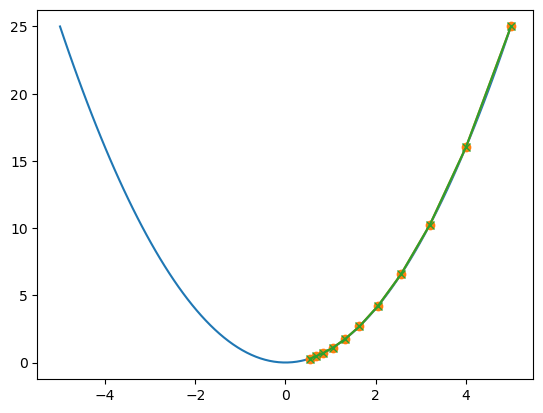

In [3]:
def function(x):
    return x**2

def analytical_gradient(x):
    return 2*x

def gradient_descent(starting_point, learning_rate, num_iterations, solver="analytical"):
    x = starting_point
    trajectory_x = [x]
    trajectory_y = [function(x)]

    if solver == "analytical":
        grad = analytical_gradient    
    elif solver == "jax":
        grad = jax_grad(function)
        x = jnp.float64(x)
        learning_rate = jnp.float64(learning_rate)

    for _ in range(num_iterations):
        
        x = x - learning_rate * grad(x)
        trajectory_x.append(x)
        trajectory_y.append(function(x))

    return trajectory_x, trajectory_y

x = np.linspace(-5, 5, 100)
plt.plot(x, function(x), label="f(x)")

descent_x, descent_y = gradient_descent(5, 0.1, 10, solver="analytical")
jax_descend_x, jax_descend_y = gradient_descent(5, 0.1, 10, solver="jax")

plt.plot(descent_x, descent_y, label="Gradient descent", marker="o")
plt.plot(jax_descend_x, jax_descend_y, label="JAX", marker="x")

### A more advanced example

/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


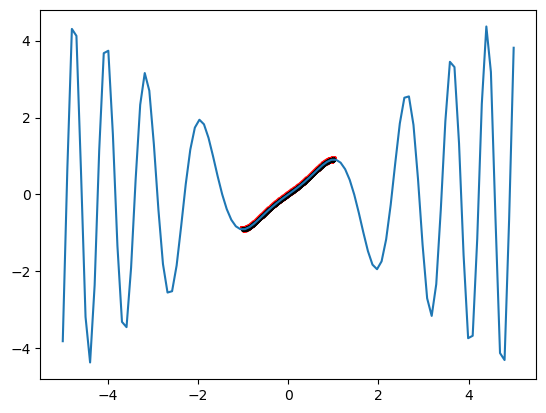

In [4]:
backend = np

def function(x):
    return x*backend.sin(x**2 + 1)

def analytical_gradient(x):
    return backend.sin(x**2 + 1) + 2*x**2*backend.cos(x**2 + 1)


x = np.linspace(-5, 5, 100)
plt.plot(x, function(x), label="f(x)")

descent_x, descent_y = gradient_descent(1, 0.01, 300, solver="analytical")

# Change the backend to JAX
backend = jnp
jax_descend_x, jax_descend_y = gradient_descent(1, 0.01, 300, solver="jax")

plt.scatter(descent_x, descent_y, label="Gradient descent", marker="v", s=10, color="red") 
plt.scatter(jax_descend_x, jax_descend_y, label="JAX", marker="x", s=5, color="black")